# **RANS CFD on 2D CRM Airfoil**

![image_head](../thumbnails/2D_CRM_airfoil.png)

This notebook shows how to set up and run a 2D airfoil simulation using the Flow360 python API.

Flow360 is not able to run true 2D simulations, however we can use the quasi-3D approach to simulate 2D flows. This is done by extruding the 2D geometry a small distance in the spanwise direction and applying symmetry boundary conditions on the two side faces.

Geometry for this tutorial was created using Engineering Sketch Pad (ESP) and is already provided. For more information about the geometry creation process, please refer to the [Geometry creation of 2D CRM airfoil using ESP](https://https://docs.flexcompute.com/projects/flow360/en/latest/tutorials/Multielement_Configuration/Multielement_Configuration.html) tutorial.

We will walk through all the steps such as importing Flow360 modules, creating a project and assigning simulation parameters.

Additionally, we will use the function `fl.AerospaceCondition.from_mach_reynolds()`, which is often used when running workshop cases. It allows us to define operating conditions using a specified mach and reynolds number.

In order to get a closer look at how we define each parameter, we will first split the simulation parameters into smaller parts, which will be assembled later on.

As a first step, we will import all dependencies.

In [1]:
# flow360 imports
import flow360 as fl
from flow360.examples import Tutorial2DCRM

## Project creation
We then create a **Flow360 Project** variable, which will be used to do operations on the geometry as well as running the case. This includes both creating the surface and volume meshes as well as running the flow solution. This project will appear in your Flow360 account on the WEBUI.

In [2]:
# Download files associated with the tutorial
Tutorial2DCRM.get_files()

# Create project variable
project = fl.Project.from_geometry(
    Tutorial2DCRM.geometry, name="Tutorial 2D CRM from Python"
)

# Create geometry variable
geometry = project.geometry

# assign the correct face and edge groupings to the geometry
geometry.group_faces_by_tag("faceName")
geometry.group_edges_by_tag("edgeName")

[14:26:33] INFO: The file (2D_CRM_geometry.csm) is being downloaded, please wait.

Output()

[14:26:50] INFO: Geometry successfully submitted:                                                                  
                   type        = Geometry                                                                          
                   name        = Tutorial 2D CRM from Python                                                       
                   id          = geo-c48d40ca-fc38-4bf3-90ce-ae23774d9b38                                          
                   status      = uploaded                                                                          
                   project id  = prj-31637662-3d26-4038-bb41-69641da3a977                                          
           

           INFO: Waiting for geometry to be processed.

Output()

## Defining simulation parameters
Once the geometry is processed, we can create separate variables for:
- [Entities and volume zones](#Entities-and-volume-zones)
- [Meshing parameters](#Meshing-parameters)
- [Reference geometry](#Reference-geometry)
- [Operating condition](#Operating-condition)
- [Time stepping](#Time-stepping)
- [Models](#Models)
- [Outputs](#Outputs)

A helpful statement we will use is `with fl.SI_unit_system:`, which allows us to automatically assign SI units to parameters. 

We still need to manually define the unit for angle as there is no default angle unit when using `with fl.SI_unit_system:`.

### Entities and volume zones
`fl.Cylinder` entities are used to create mesh refinement regions.

A `fl.AutomatedFarfield` volume zone is used to define the circular flow field simulation volume zone farfield and symmetry planes boundary models.

In [3]:
# Choosing a unit system
with fl.SI_unit_system:

    # Cylinder entities used for mesh refinements
    cylinders = [
        fl.Cylinder(
            name=f"cylinder{i+1}",
            axis=[0, 1, 0],
            center=[0.7, 0.5, 0],
            outer_radius=outer_radius,
            height=1.0,
        )
        for i, outer_radius in enumerate([1.1, 2.2, 3.3, 4.5])
    ]
    cylinder5 = fl.Cylinder(
        name="cylinder5",
        axis=[-1, 0, 0],
        center=[6.5, 0.5, 0],
        outer_radius=6.5,
        height=10,
    )

    # Farfield used for creating a volume zone and assigning appropriate models
    farfield = fl.AutomatedFarfield(name="farfield", method="quasi-3d")

[14:27:20] INFO: using: SI unit system for unit inference.

### Meshing parameters
In this section we will assign settings so that our mesh will have sufficient level of refinement for this case.

Default settings describe how the mesh will be created globally. Refinements allow for much more precise control of the mesh in regions of interest.

Here we will utilize the previously created cylinder entities, farfield, and we will also refer to geometry's faces and edges, which were grouped in the [Project creation](#Project-creation) step.

As you can see in the image below, we define multiple refinements regions in order to better capture flow features around the geometry and in the wake region.

![image_refinements](figures/2D_CRM_airfoil_refinement_cylinders.png)

In the image below we can see the cylindrical flowfield volume zone created using the `fl.AutomatedFarfield` class with the 2D foil at its center. We can also see the effect of the wake refinement region behind the airfoil.


![image_mesh_slice](figures/2D_CRM_farfield_slice.png)



In [4]:
with fl.SI_unit_system:
    meshing_params = fl.SimulationParams(
        meshing=fl.MeshingParams(
            # Default settings for meshing
            defaults=fl.MeshingDefaults(
                surface_edge_growth_rate=1.17,
                surface_max_edge_length=1.1,
                curvature_resolution_angle=12 * fl.u.deg,
                boundary_layer_growth_rate=1.17,
                boundary_layer_first_layer_thickness=1.8487111e-06,
            ),
            # Adjust all spacings in refinement regions
            refinement_factor=1.35,
            # Adjust narrow gap treatment strength for two surfaces in close proximity.
            gap_treatment_strength=0.5,
            # Crete new volume zones
            volume_zones=[farfield],
            # Additional fine-tuning for refinements on top of defaults
            refinements=[
                # cylindrical refinement regions to capture the flow around the foil
                fl.UniformRefinement(
                    name="refinement1", spacing=0.1, entities=[cylinders[0]]
                ),
                fl.UniformRefinement(
                    name="refinement2", spacing=0.15, entities=[cylinders[1]]
                ),
                fl.UniformRefinement(
                    name="refinement3", spacing=0.225, entities=[cylinders[2]]
                ),
                fl.UniformRefinement(
                    name="refinement4", spacing=0.275, entities=[cylinders[3]]
                ),
                # cylindrical refinement region to capture the wake
                fl.UniformRefinement(
                    name="refinement5", spacing=0.325, entities=[cylinder5]
                ),
                # Refine surface elements for given faces
                fl.SurfaceRefinement(
                    name="wing", max_edge_length=0.74, faces=[geometry["wing"]]
                ),
                fl.SurfaceRefinement(
                    name="flap-slat",
                    max_edge_length=0.55,
                    faces=[geometry["flap"], geometry["slat"]],
                ),
                fl.SurfaceRefinement(
                    name="trailing",
                    max_edge_length=0.36,
                    faces=[
                        # '*' allows us to select all faces ending with 'Trailing'
                        geometry["*Trailing"],
                    ],
                ),
                # Grows anisotropic layers orthogonal to the specified edges
                fl.SurfaceEdgeRefinement(
                    name="edges",
                    method=fl.HeightBasedRefinement(value=0.0007),
                    edges=[
                        # Similarly as above, we can select multiple edges using '*' expression
                        geometry["*trailingEdge"],
                        geometry["*leadingEdge"],
                    ],
                ),
                fl.SurfaceEdgeRefinement(
                    name="symmetry",
                    method=fl.ProjectAnisoSpacing(),
                    edges=[geometry["symmetry"]],
                ),
            ],
        ),
    )

           INFO: using: SI unit system for unit inference.

### Reference geometry
Now we will define the `reference_geometry` which is used to report forces such as drag and lift.

In [5]:
with fl.SI_unit_system:
    reference_geometry_params = fl.SimulationParams(
        # Create geometrical related reference values
        reference_geometry=fl.ReferenceGeometry(
            moment_center=[0.25, 0, 0], moment_length=[1, 1, 1], area=0.01
        )
    )

           INFO: using: SI unit system for unit inference.

### Operating condition
Next up is the definition of flow conditions with the help of `fl.AerospaceCondition.from_mach_reynolds()` function. It does not require knowledge of fluid properties at the desired conditions and instead allows the usage of mach number in conjunction with reynolds number. This is particularly useful for replicating workshop cases which traditionally give Mach and Reynolds number flow conditions. Viscosity are density are going to be automatically calculated based on the input parameters.

>Note: In this case we are assigning the reynolds number based on the mesh unit length (1 meter). For convenience's sake, the foil is also built with a 1 meter chord. Thus the reynolds number based on chord length will be the same as the one based on mesh unit length.

In [6]:
with fl.SI_unit_system:
    operating_condition_params = fl.SimulationParams(
        # Create operating conditions using mach and reynolds number
        operating_condition=fl.AerospaceCondition.from_mach_reynolds(
            mach=0.2,
            reynolds_mesh_unit=5e6,
            temperature=272.1,
            alpha=16 * fl.u.deg,
            beta=0 * fl.u.deg,
            project_length_unit=1 * fl.u.m,
        ),
    )

           INFO: using: SI unit system for unit inference.

           INFO: Density and viscosity were calculated based on input data, ThermalState will be automatically     
           created.

### Time stepping
This simulation will be run as a Steady State case so we will use the `fl.Steady()` time stepping class.

CFL is the Courant–Friedrichs–Lewy condition which we specify using the `fl.AdaptiveCFL()` class. This allows Flow360 to automatically adjust the CFL number during the simulation in order to achieve faster convergence. For more information about `fl.AdaptiveCFL()` and its usage, please refer to the [documentation](https://docs.flexcompute.com/projects/flow360/en/latest/python/api/_autosummary/flow360.AdaptiveCFL.html#flow360.AdaptiveCFL).

In [7]:
with fl.SI_unit_system:
    time_stepping_params = fl.SimulationParams(
        # Time stepping settings for Steady State simulation
        time_stepping=fl.Steady(max_steps=3000, CFL=fl.AdaptiveCFL()),
    )

           INFO: using: SI unit system for unit inference.

### Models
This parameter is used to define solver settings, numerical models and boundary conditions within our simulation.

Please note that the `fl.AutomatedFarfield(name="farfield", method="quasi-3d")` call above automatically created the necessary surfaces for the farfield and symmetry planes, which we can now refer to when creating boundary conditions.

In [8]:
with fl.SI_unit_system:
    models_params = fl.SimulationParams(
        # Solver settings, numerical models and boundary conditions
        models=[
            # Create wall boundary condition
            fl.Wall(
                surfaces=[
                    # Here we use '*' to select all surfaces
                    geometry["*"],
                ],
                name="wall",
            ),
            # Create freestream boundary condition
            fl.Freestream(surfaces=farfield.farfield, name="Freestream"),
            # Create slip wall boundary condition
            fl.SlipWall(surfaces=farfield.symmetry_planes, name="slipwall"),
            # Create fluid volume model
            fl.Fluid(
                # Set up compressible Navier-Stokes solver
                navier_stokes_solver=fl.NavierStokesSolver(
                    linear_solver=fl.LinearSolver(max_iterations=35), kappa_MUSCL=0.33
                ),
                # Set up turbulence solver based on the Spalart-Allmaras model
                turbulence_model_solver=fl.SpalartAllmaras(
                    linear_solver=fl.LinearSolver(max_iterations=25),
                    equation_evaluation_frequency=1,
                ),
            ),
        ],
    )

           INFO: using: SI unit system for unit inference.

### Outputs
Here we will specify which outputs we want Flow360 to produce for us.

In [9]:
# define the output fields we want
volume_outputs = [
    "primitiveVars",
    "vorticity",
    "residualNavierStokes",
    "residualTurbulence",
    "Cp",
    "Mach",
    "qcriterion",
    "mut",
]
surface_outputs = [
    "primitiveVars",
    "Cp",
    "Cf",
    "CfVec",
    "yPlus",
]

with fl.SI_unit_system:
    outputs_params = fl.SimulationParams(
        outputs=[
            # Specify the volume field output in tecplot format
            fl.VolumeOutput(
                output_format="tecplot",
                name="fl.VolumeOutput",
                output_fields=volume_outputs,
            ),
            # Specify the surface output over the whole geometry in tecplot format
            fl.SurfaceOutput(
                output_format="tecplot",
                name="fl.SurfaceOutput",
                surfaces=geometry["*"],
                output_fields=surface_outputs,
            ),
            # Create a slice output at Y=0.005m in tecplot format.
            # Because the extrusion direction is along the Y axis from y=0m to y=0.01m, this slice is at the mid-plane of the quasi-3D geometry.
            fl.SliceOutput(
                output_format="tecplot",
                output_fields=volume_outputs,
                slices=[
                    # define the fl.Slice from which we will be exporting the data
                    fl.Slice(
                        name="Y=0.005m slice", normal=[0, 1, 0], origin=[0, 0.005, 0]
                    )
                ],
            ),
        ],
    )

           INFO: using: SI unit system for unit inference.

### Combining parameters
After having created various instances of the `SimulationParams` class, we can now combine them into one final instance containing all of the parameters defined previously.
Flow360 allows us to refer to each parameter specified within `SimulationParams`, for example using `meshing_params.meshing`, we can access meshing parameters within that variable.

In [10]:
with fl.SI_unit_system:
    params = fl.SimulationParams(
        meshing=meshing_params.meshing,
        reference_geometry=reference_geometry_params.reference_geometry,
        operating_condition=operating_condition_params.operating_condition,
        time_stepping=time_stepping_params.time_stepping,
        models=models_params.models,
        outputs=outputs_params.outputs,
    )

           INFO: using: SI unit system for unit inference.

## Running the case
With all of our parameters defined, we can pass them to our project and run the case.

In [11]:
case = project.run_case(params=params, name="Case of tutorial 2D CRM from Python")

           INFO: Density and viscosity were calculated based on input data, ThermalState will be automatically     
           created.

           INFO: using: SI unit system for unit inference.

[14:27:24] INFO: Successfully submitted:                                                                           
                   type        = Case                                                                              
                   name        = Case of tutorial 2D CRM from Python                                               
                   id          = case-4efa0876-8163-4a90-aba4-c86b0709d7a9                                         
                   status      = pending                                                                           
                   project id  = prj-31637662-3d26-4038-bb41-69641da3a977                                          
           

## Post processing
After we have successfully run the simulation, we can post process our results. We will use the `wait()` method to ensure that the case has finished running before we start to download the results and plot the variables of interest's convergence history.

In [12]:
case.wait()

Output()

Next we can download the results.
We will be looking at the post processing of these quantities:
- total forces
- nonlinear residuals
- CFL
- total CD along the X axis

In [13]:
total_forces = case.results.total_forces
total_forces = total_forces.as_dataframe()

nonlinear_residuals = case.results.nonlinear_residuals
nonlinear_residuals = nonlinear_residuals.as_dataframe()

cfl = case.results.cfl
cfl = cfl.as_dataframe()

x_slicing_force_distribution = case.results.x_slicing_force_distribution
x_slicing_force_distribution.wait()
x_slicing_force_distribution = x_slicing_force_distribution.as_dataframe()

Output()

[14:38:11] INFO: Saved to /tmp/tmpdge4mrr8/3e931599-a2aa-4c3a-ac12-d9045a401709.csv

Output()

[14:38:12] INFO: Saved to /tmp/tmpdge4mrr8/31f72d87-2582-4ef4-bb05-508352253926.csv

Output()

[14:38:13] INFO: Saved to /tmp/tmpdge4mrr8/bf873e8e-e098-4c6f-b9c3-4154de221ff9.csv

Output()

[14:38:14] INFO: Saved to /tmp/tmpdge4mrr8/1facbeb1-85c9-419a-8d61-d9fba2cac766.csv

In order to obtain the X and Y variable names for our CFL plots, we will print out the CFL dataframe and look at its column names.

In [14]:
print(cfl)

     physical_step  pseudo_step  0_NavierStokes_cfl  1_SpalartAllmaras_cfl
0                0            0            1.000000               1.000000
1                0           10            1.103010               1.104622
2                0           20            1.218409               1.220190
3                0           30            1.345881               1.347849
4                0           40            1.486690               1.488864
..             ...          ...                 ...                    ...
296              0         2960           45.452285              32.553325
297              0         2970           45.451042              32.547860
298              0         2980           45.450845              32.553560
299              0         2990           45.451828              32.532039
300              0         2999           45.453959              32.517152

[301 rows x 4 columns]


First, we will look at how the non-linear residuals converge.

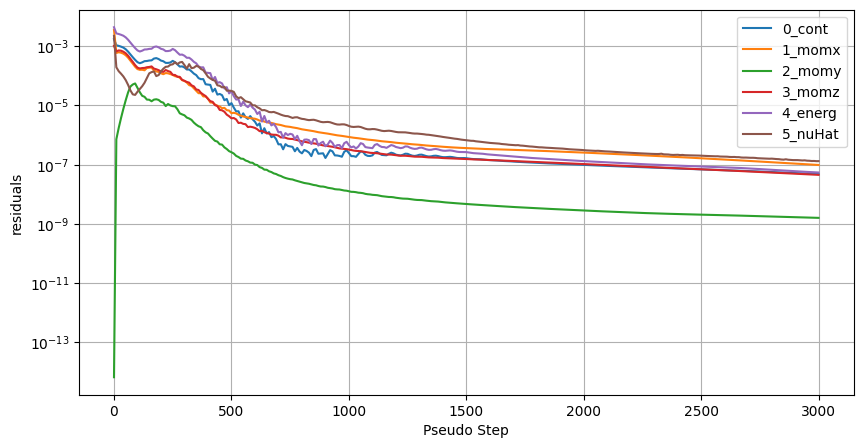

In [15]:
ax = nonlinear_residuals.plot(
    x="pseudo_step",
    y=["0_cont", "1_momx", "2_momy", "3_momz", "4_energ", "5_nuHat"],
    logy=True,
    xlabel="Pseudo Step",
    ylabel="residuals",
    figsize=(10, 5),
)
ax.grid(True)

Next we will look at the CFL values for both the Navier-Stokes solver and the turbulence model solver.

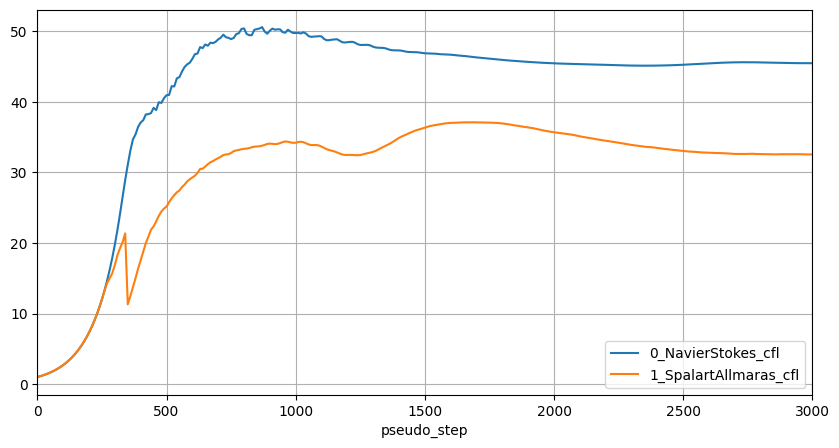

In [16]:
ax = cfl.plot(
    x="pseudo_step",
    y=["0_NavierStokes_cfl", "1_SpalartAllmaras_cfl"],
    xlim=(0, 3000),
    figsize=(10, 5),
)
ax.grid(True)

Another popular form of checking conversion convergence for aerodynamic applications is monitoring how the CL and CD values stabilize during the simulation.

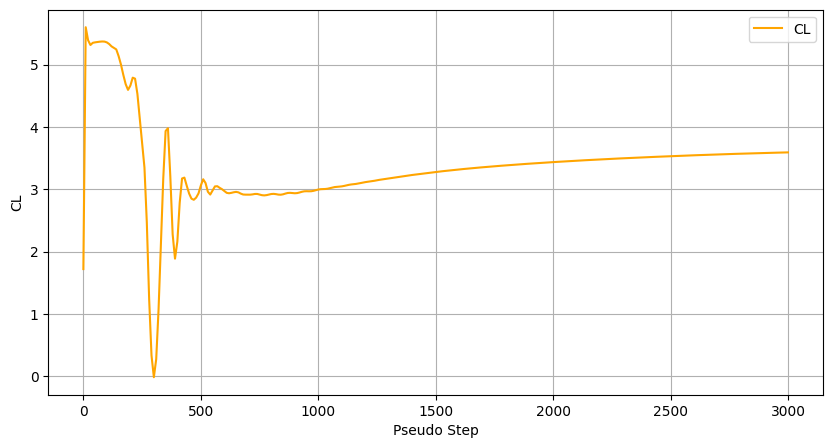

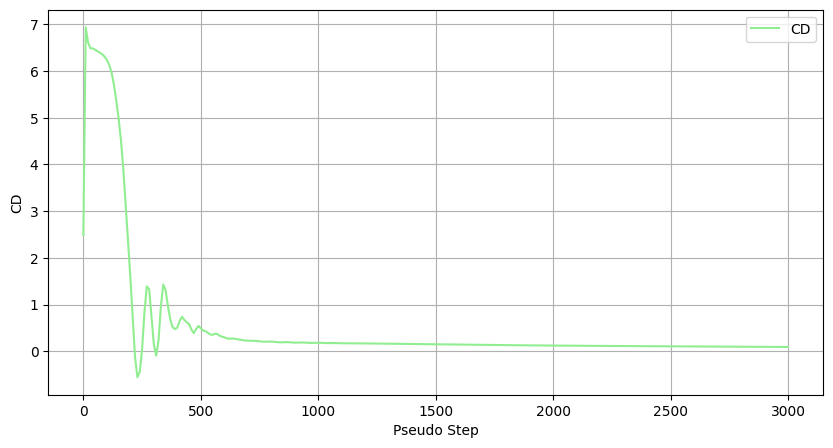

In [17]:
ax = total_forces.plot(
    x="pseudo_step",
    y="CL",
    xlabel="Pseudo Step",
    ylabel="CL",
    figsize=(10, 5),
    style="orange",
)
ax.grid(True)

ax = total_forces.plot(
    x="pseudo_step",
    y="CD",
    xlabel="Pseudo Step",
    ylabel="CD",
    figsize=(10, 5),
    style="lightgreen",
)
ax.grid(True)

Finally, we will look at how the CD varies along the chord of the 2D foil.

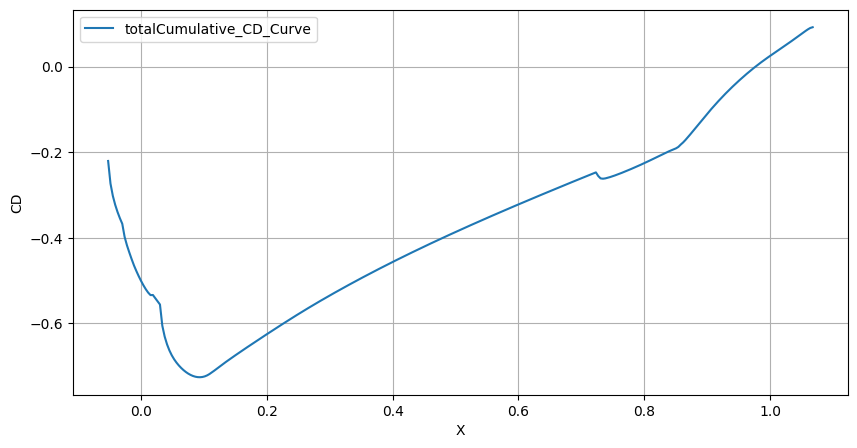

In [18]:
ax = x_slicing_force_distribution.plot(
    x="X", y="totalCumulative_CD_Curve", xlabel="X", ylabel="CD", figsize=(10, 5)
)
ax.grid(True)